## Global analysis of human low-complexity sequences in the human proteom
#### Last updated 2022-08-31

The notebook here contains analysis to explore distinct types of low-complexity sequences in the human proteome.

## Data used
This notebook uses several different sources for data annotations
## Global PTM analysis of human proteome
#### Last updated 2022-08-12

The notebook here contains a global analysis of post-translational modifications across the human proteome with respect to solvent accessibility. 

## Data used
This notebook uses several different sources for data annotations

#### A comment on the predicted intrinsically disordered regions
The disordered regions identified here were predicted using [metapredict V2](https://www.biorxiv.org/content/10.1101/2022.06.06.494887v1), a recent update to our [metapredict](http://dx.doi.org/10.1016/j.bpj.2021.08.039) disorder predictor. For insight into how this works and the potential caveats, please see the associated papers or the [metapredict documentation](https://metapredict.readthedocs.io/).

#### A comment on low-complexity identification
Polar-rich low-complexity domains were identified using the approach introduced by Gutierrez et al.. This approach is implemented in the sequence analysis tool [sparrow](https://github.com/idptools/sparrow). Whole sparrow is currently in development, we provide it here as a reference implementation for low-complexity analysis in this way. 

### Publication references
Emenecker, R. J., Griffith, D., & Holehouse, A. S. (2021). Metapredict: a fast, accurate, and easy-to-use predictor of consensus disorder and structure. Biophysical Journal, 120(20), 4312–4319.

Emenecker, R. J., Griffith, D., & Holehouse, A. S. (2022). Metapredict V2: An update to metapredict, a fast, accurate, and easy-to-use predictor of consensus disorder and structure. In bioRxiv (p. 2022.06.06.494887). https://doi.org/10.1101/2022.06.06.494887

Gutierrez, J. I., Brittingham, G. P., Karadeniz, Y., Tran, K. D., Dutta, A., Holehouse, A. S., Peterson, C. L., & Holt, L. J. (2022). SWI/SNF senses carbon starvation with a pH-sensitive low-complexity sequence. eLife, 11. https://doi.org/10.7554/eLife.70344




In [1]:
import pandas as pd 
import numpy as np

import shephard
from shephard.apis import uniprot, fasta
from shephard.interfaces import si_domains, si_tracks
from shephard.tools import domain_tools

In [2]:
### PLOTTING SETTINGS

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

AA_type_palette={'A':'#000000','I':'#000000','L':'#000000','M':'#000000','V':'#000000',
                 'F':'#f2a139','Y':'#f2a139','W':'#f2a139',
                 'D':'#eb3628','E':'#eb3628',
                 'R':'#201beb','K':'#201beb',
                 'P':'#bf42b2','C':'#fbe74f',
                 'N':'#306e22','Q':'#306e22','G':'#306e22','S':'#306e22','T':'#306e22','H':'#306e22'}

chem_type_palette={'fraction_aliphatic':'#808080',
                   'fraction_aromatic':'#f2a139',
                   'FCR':'#C03D3E',
                   'fraction_proline':'#bf42b2',
                   'fraction_cystine':'#fbe74f',
                   'fraction_polar':'#3A923A'}

aro_palette = sns.light_palette('#f2a139', reverse=False, as_cmap=True)
charge_palette = sns.light_palette('#C03D3E', reverse=False, as_cmap=True)
ali_palette = 'Greys'
chem_order = {'aliphatic':'#808080',
                   'aromatic':'#f2a139',
                   'charge':'#C03D3E',
                   'proline':'#bf42b2',
                   'cystine':'#fbe74f',
                   'polar':'#3A923A'}


def show_values(axs, orient="v", space=.01):
    """
    Addapted from:
    https://www.statology.org/seaborn-barplot-show-values/
    """
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.3f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.3f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

## Read in human data 

In [3]:
# read in human IDRs and a track with all the aromatic residues annotated

# read in the human proteome from a uniprot-derived FASTA file
filename ='../shprd_data/human_proteome_validated.fasta'
human_prot = uniprot.uniprot_fasta_to_proteome(filename)

print('Reading in data...')

# load IDRs
si_domains.add_domains_from_file(human_prot, '../shprd_data/shprd_domains_idrs_metapredict_v2.tsv') # metapredict2 IDRS

# read in all prion-like domains in the human proteome, as defined by plaac on default settings. 
si_domains.add_domains_from_file(human_prot, '../shprd_data/shprd_domains_human_plaac_PLDs.tsv')

# read in all the polar-rich low-complexity domains. These are defined using the approach developed
# for work on glutamine-rich low complexity sequences (Gutierrez et al., eLife 2022) and the code
# to identify these regions is implemented in the sequence analysis package sparrow,
# which is public but in development
si_domains.add_domains_from_file(human_prot, '../shprd_data/shprd_domains_human_QSGNTP_LCD.tsv')

# read in a values track that reports 0 or 1 for where aromatic residues are found in human proteins
si_tracks.add_tracks_from_file(human_prot,'../shprd_data/shprd_tracks_human_aromatic_resis.tsv', 'values')
print('...done!')



Reading in data...
...done!


### Identify LCDs + analyze amino acid fractions and domain overlap

The this cell walks through all the polar-rich low-complexity domains in the human proteome (which we define using the domain type `QSGNTP_LCD`) and calculates some sequence properties as well as determines if they overlap with intrinsically disordered regions (IDRs) and/or prion-like domains (PLDs).

The `QSGNTP_LCD` domains were calculated using the sequence analysis package [sparrow](https://github.com/idptools/sparrow) - we note that SPARROW is not currently ready for public use, but we're very close! If you want to use it please consider reaching out to [Alex](https://www.holehouselab.com/team) to double check what you're doing and how you're doing it just to make sure things work correctly!



In [4]:

# initialize some counters
overlap_count_idrs = 0
overlap_count_plds = 0

# as a curiosity, we can also 
non_overlapping_lcds = []

# for each protein in the human proteome
for p in human_prot:
        
    # for all the polar-rich low complexity domains
    for d in p.get_domains_by_type('QSGNTP_LCD'):

        # calculate sequence statistics for each LCD domain

        # get domain length 
        d_len = len(d.sequence)

        # calculate the fraction of aromatic residues in this domain
        d.add_attribute('fraction_aromatic', sum(d.get_track_values('aromatic_resi_track'))/ d_len)

        # calculate fraction of charged residues
        d.add_attribute('FCR', sum(map(d.sequence.count, ['D','E','R','K'])) / d_len)
        
        # calculate fraction of aliphatic residues
        d.add_attribute('fraction_aliphatic', sum(map(d.sequence.count, ['A','L','V','I','M'])) / d_len)
        
        # calculate fraction of polar residues
        d.add_attribute('fraction_polar', sum(map(d.sequence.count, ['Q','S','G', 'N', 'T',])) / d_len)
        
        # calculate fraction of histidine
        d.add_attribute('fraction_proline', sum(map(d.sequence.count, ['P'])) / d_len)

        # annotate polar_LCDs that overlap with IDRs (overlap is defined 
        # very loosely as an overlap by 1 residue or more)        
        # for each IDR ask if there's overlap
        for idr in p.get_domains_by_type('IDR'):
            
            # test for any overlap 
            if domain_tools.domain_overlap(d, idr): 
                
                # if found, add this as a domain attribute, increment the counter
                # and break for this search
                d.add_attribute('IDR_overlap', True)
                overlap_count_idrs = overlap_count_idrs + 1
                break

        # do exactly the same thing but this time for prion-like domains
        # for each prion like domain (PLD)
        for pld in p.get_domains_by_type('plaac_pld'):
            if domain_tools.domain_overlap(d,pld): 
                d.add_attribute('PLD_overlap', True)
                overlap_count_plds = overlap_count_plds + 1
                break

                
        
print(f"There are {len(human_prot.get_domains_by_type('IDR'))} IDRs in the human proteome")
print(f"There are {len(human_prot.get_domains_by_type('QSGNTP_LCD'))} polar-rich low-complexity domains in the human proteome")
print(f"There are {len(human_prot.get_domains_by_type('plaac_pld'))} PLAAC-derived PLDs in the human proteome")


print('-------------------')        
print(f"Number of QSGNTP_LCD domains that overlap with IDRs: {overlap_count_idrs}")
print(f"Number of QSGNTP_LCD domains that overlap with PLDs: {overlap_count_plds}")

There are 33563 IDRs in the human proteome
There are 5138 polar-rich low-complexity domains in the human proteome
There are 361 PLAAC-derived PLDs in the human proteome
-------------------
Number of QSGNTP_LCD domains that overlap with IDRs: 5032
Number of QSGNTP_LCD domains that overlap with PLDs: 372


### Generate a proteome attribute for  polar-rich LDSs that overlap IDRs
The cell below creates a shortcut for the list of overlapping LCDs by generating a list of these domains and then adding them as a Proteome attribute

In [5]:
# initialize empty list
lcd_idr_overlap =[]

# iterate over all polar-rich LCDs
for d in human_prot.get_domains_by_type('QSGNTP_LCD'):
    if 'IDR_overlap' in d.attributes:
        lcd_idr_overlap.append(d)

# save list as proteome attribute for quick access
human_prot.add_attribute('lcd_idr_overlap', lcd_idr_overlap)

### Calculate depletion thresholds for different types of chemisty
In the next cel

In the code below we're going to:

1. Build lists of amino acid composition for all polar-rich LCDs in the order in which domains appear in the `lcd_idr_overlap` attribute
2. Calculate a 'depletion' threshold; this is a threshold we set to find LCD_IDRs that are depleted for a certain type of residue. In this case we are generating an attribute which is itself a function that dynamically returns the fraction of a given property associated with a percentile of interest. This means rather than pre-computing these thresholds we are adding a new function to our proteome that can dynamically calculate a property of interest, in effect extending the software capabilities of SHEPHARD to meet our needs.

In [6]:
## Creating callable proteome attributes for hyper-adaptability ## 

# create cumulitive lists of domain attribute amino acid fractions for all of the lcd_idr_overlap LCDs
# here we call the previous created list (lcd_idr_overlap) from the proteome attribute 
lcd_idr_domains = human_prot.attribute('lcd_idr_overlap')

# get lists of domain sequence properties (FCR, fraction aromatic, fraction aliphatic). 
FCR_list = [d.attribute('FCR') for d in lcd_idr_domains]
fraction_aromatic_list = [d.attribute('fraction_aromatic') for d in lcd_idr_domains]
fraction_aliphatic_list = [d.attribute('fraction_aliphatic') for d in lcd_idr_domains]

# save percentile cutoff lambda functions as a proteome attributes that can be called later
human_prot.add_attribute('LCD_FCR_threshold_fxn', lambda p: np.percentile(np.array(FCR_list), p))
human_prot.add_attribute('LCD_aromatic_threshold_fxn', lambda p: np.percentile(np.array(fraction_aromatic_list), p))
human_prot.add_attribute('LCD_aliphatic_threshold_fxn', lambda p: np.percentile(np.array(fraction_aliphatic_list), p))



When the functions defined here are called, they take a value (p) and that value should be a percentile (i.e. a number) between 0 and 100. In return, the function returns an amino acid fraction that corresponds to that percentile. 

An example of how this works in practice is shown in the cell below.


10th percentile aromatic fraction cutoff: 0.0101


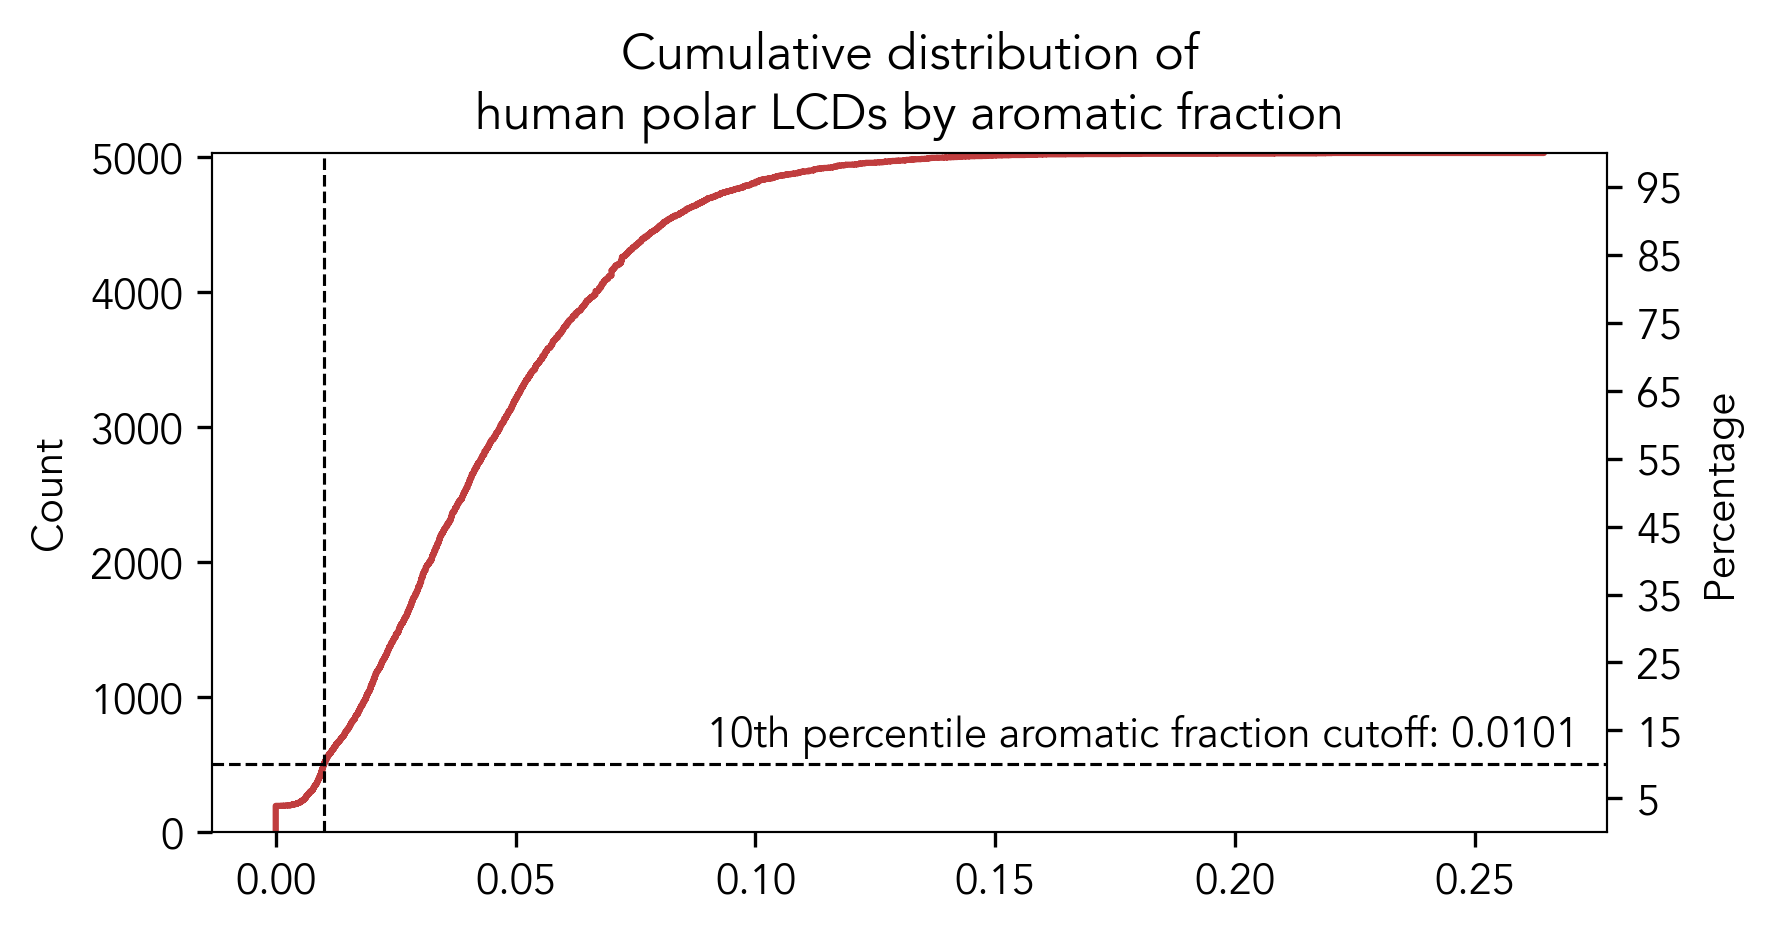

In [7]:
# Example plotting and calling the proteome attribute percentile functions

# first we're going to define our threshold of interest as the 10th percentile, and make this focus on aromatic 
percentile = 10
chemical_type = 'aromatic'
local_list = fraction_aromatic_list

# call attribute function passing percentile to calculate what the fraction of 
# aromatic residue in LCD_IDRs is at the 10th-percentile 
l_cutoff = human_prot.attribute(F'LCD_{chemical_type}_threshold_fxn')(percentile)

f, ax = plt.subplots(1,1, figsize=(6, 3), dpi=150, facecolor='w', edgecolor='k')
cp = sns.ecdfplot(x=local_list,stat='count', ax=ax, c='#C03D3E')

cp.set_title(f'Cumulative distribution of\nhuman polar LCDs by {chemical_type} fraction')

total_samples = len(local_list)
cax = cp.axes
# bounds of the left y-axis:
ymin, ymax = cax.get_ylim()    
# Create second y-axis for the percentages on the right    
ax1 = cax.twinx()
ax1.set_ylabel('Percentage')
ax1.set_yticks(np.arange(5,105,10))
# scale right axis labels to total samples and mutliply with 100 for percentages
ax1.set_ylim(100*ymin/total_samples, 100*ymax/total_samples)

# return 10th percentile value plot line and text on figure 
print(f'{percentile}th percentile {chemical_type} fraction cutoff: {np.round(l_cutoff,4)}')

f.text(0.4,.22, f'{percentile}th percentile {chemical_type} fraction cutoff: {np.round(l_cutoff,4)}')

# plot horizontal line at the cutoff
cp.axvline(l_cutoff, ls='--', c='k',lw=.75)

# plot verticle line at the percentile
cp.axhline((percentile/100)*len(human_prot.attribute('lcd_idr_overlap')), ls='--', c='k',lw=.75)

## Summary
The approach described above hopefully makes it clear how one could slice-n-dice human IDRs into distinct compositional subclasses using empyrically-derived thresholds. More generally though, doing so using SHEPHARD can actually be accomplished in just a few lines of code. 



## Plotting and visualization of the LCDs extracted based off of thresholds 

Having established a simple way to define depletion or enrichment thresholds for polar-rich LCD_IDRs (as a reminder, these are polar-rich low complexity domains that also overlap with intrinsically disordered regions), we next decided to explore which types of proteins or regions are associated with specific chemical flavors of these domains.

The cell below constructs a single large Pandas dataframe that for each LCD_IDR provides sequence properties for

In [8]:
# For convenience and formating the specific data of interest is exported into a dataframe 
# Plotting is done in seaborn 

# get data for extracted LCDs 
eIDR_proteins = []
eIDR_idrs = []
eIDR_FCR =[]
eIDR_aromatic=[]
eIDR_aliphatc=[]
eIDR_polar=[]
eIDR_proline=[]


# for each polar-rich LCD that overlaps with an IDR calculate 
# sequence properties and add into a set of lists
for d in human_prot.attribute('lcd_idr_overlap'):
    
    # fraction of charged residue
    eIDR_FCR.append(float(d.attribute('FCR'))+0.000000001)
    
    # fraction of aromatic residues
    eIDR_aromatic.append(float(d.attribute('fraction_aromatic'))+0.000000001)
    
    # fraction of aliphatic residues
    eIDR_aliphatc.append(float(d.attribute('fraction_aliphatic'))+0.000000001)
    
    # fraction of polar residues
    eIDR_polar.append(float(d.attribute('fraction_polar'))+0.000000001)
    
    # fraction of proline residues
    eIDR_proline.append(float(d.attribute('fraction_proline'))+0.000000001)
    
    # fraction of the unique ID of the protein this domain comes from
    eIDR_proteins.append(d.protein.unique_ID) 
    
    # the domain itself 
    eIDR_idrs.append(d) 
    
# build a data frame with these parameters    
lcd_idr_overlap_data = pd.DataFrame({'IDR':eIDR_idrs,
                                     'protein':eIDR_proteins,
                                     'FCR':eIDR_FCR, 
                                     'fraction_aromatic':eIDR_aromatic,
                                    'fraction_aliphatic':eIDR_aliphatc, 
                                     'fraction_polar':eIDR_polar, 
                                     'fraction_proline':eIDR_proline})

# expand that dataframe by adding some additional columns

# fraction charged and aliphatic
lcd_idr_overlap_data['FCR_aliphatic'] = lcd_idr_overlap_data['FCR']+ lcd_idr_overlap_data['fraction_aliphatic']

# fraction charged and aromatic
lcd_idr_overlap_data['FCR_aromatic'] = lcd_idr_overlap_data['fraction_aromatic']+ lcd_idr_overlap_data['FCR']

# fraction aliphatic and aromatic
lcd_idr_overlap_data['aliphatic_aromatic'] = lcd_idr_overlap_data['fraction_aromatic'] + lcd_idr_overlap_data['fraction_aliphatic']

# fraction aromatic divided by fraction aliphatic + charged 
lcd_idr_overlap_data['relative_aromatic'] = lcd_idr_overlap_data['fraction_aromatic'] / (lcd_idr_overlap_data['FCR']+ lcd_idr_overlap_data['fraction_aliphatic'])

# fraction aliphatic divided by fraction aromatic + charged 
lcd_idr_overlap_data['relative_aliphatic'] = lcd_idr_overlap_data['fraction_aliphatic'] / (lcd_idr_overlap_data['fraction_aromatic']+ lcd_idr_overlap_data['FCR'])

# fraction charged divided by fraction aromatic and aliphatic 
lcd_idr_overlap_data['relative_FCR'] = lcd_idr_overlap_data['FCR'] / (lcd_idr_overlap_data['fraction_aromatic']+ lcd_idr_overlap_data['fraction_aliphatic'])

# domain lengths 
lcd_idr_overlap_data['len'] =  lcd_idr_overlap_data['IDR'].apply(lambda d: len(d))

# domain types
lcd_idr_overlap_data['domain_type'] =  lcd_idr_overlap_data['IDR'].apply(lambda d: d.domain_type)

# protein name
lcd_idr_overlap_data['info'] =  lcd_idr_overlap_data['IDR'].apply(lambda d: d.protein.name.split("|")[2].split('OS=')[0])

# position in the protein where domain comes from
lcd_idr_overlap_data['position'] =  lcd_idr_overlap_data['IDR'].apply(lambda d: "%i-%i" % (d.start,d.end))

# sequence
lcd_idr_overlap_data['seq'] =  lcd_idr_overlap_data['IDR'].apply(lambda d: d.sequence)




### Some optional things
We have two optional calls which can be run if we want to write colored strings for the Bokeh plot creation (needs only be done once) and save the output of the analysis above to Excel (.xls) file.

By default both of these are turned off because they required additional packages to be installed, but we've left them as options because they were used on generating the figures and analyses for this paper.

Note that to finally convert these regions into Bokeh plots, you must also run the appropriately-named `generate_interactive_bokeh_plot.ipynb` notebook found in this directory.

In [9]:
WRITE_FOR_BOKEH = False
SAVE_TO_EXCEL = False

if WRITE_FOR_BOKEH:
    from sparrow import Protein 
    lcd_idr_overlap_data['pp_seq'] =  lcd_idr_overlap_data['seq'].apply(lambda s: Protein(s).show_sequence(return_raw_string=True, fontsize=10))
    lcd_idr_overlap_data.to_csv('data_for_bokeh_plots.csv')

if SAVE_TO_EXCEL:
    try:
        import xlwt
        lcd_idr_overlap_data.to_excel('../generated_data/polar_rich_LCD_statistics.xls')
    except ModuleNotFoundError:
        print('To use the pandas to_excel() function requires xlwt which is not a\ndefault requirement for pandas installation. To install this please run\n\npip install xlwt\n')
    
    

### Extract some LCDs
The code below defines fractional composition percentiles, and then builds new dataframes based on logical operations that filter LCD_IDRs based on composition.

For example:

    aromatic_polar_lcds = lcd_idr_overlap_data[(lcd_idr_overlap_data['FCR'] < FCR_cutoff) & (lcd_idr_overlap_data['fraction_aliphatic'] < aliphatic_cutoff)]
    
Filters for LCD_IDRs where the FRC is lower than the FCR_cutoff and the fraction of aliphatic residues is depleted as well - so these sequences will be overwhelingly depleted for charged and aliphatic residues.    



In [10]:
percentile=10

aromatic_cutoff = human_prot.attribute('LCD_aromatic_threshold_fxn')(percentile)
FCR_cutoff = human_prot.attribute('LCD_FCR_threshold_fxn')(percentile) 
aliphatic_cutoff = human_prot.attribute('LCD_aliphatic_threshold_fxn')(percentile) 

aromatic_polar_lcds = lcd_idr_overlap_data[(lcd_idr_overlap_data['FCR'] < FCR_cutoff) & (lcd_idr_overlap_data['fraction_aliphatic'] < aliphatic_cutoff)]
aliphatic_polar_lcds = lcd_idr_overlap_data[(lcd_idr_overlap_data['FCR'] < FCR_cutoff) & (lcd_idr_overlap_data['fraction_aromatic'] < aromatic_cutoff)]
FCR_polar_lcds = lcd_idr_overlap_data[(lcd_idr_overlap_data['fraction_aromatic'] < aromatic_cutoff) & (lcd_idr_overlap_data['fraction_aliphatic'] < aliphatic_cutoff)]




### Plot and segragate by other residues 

Text(0.5, 0.98, 'Enrichment for polar LCD of interest: 10th percentile: Aromatic:0.0101  Aliphatic:0.1467  FCR:0.0745')

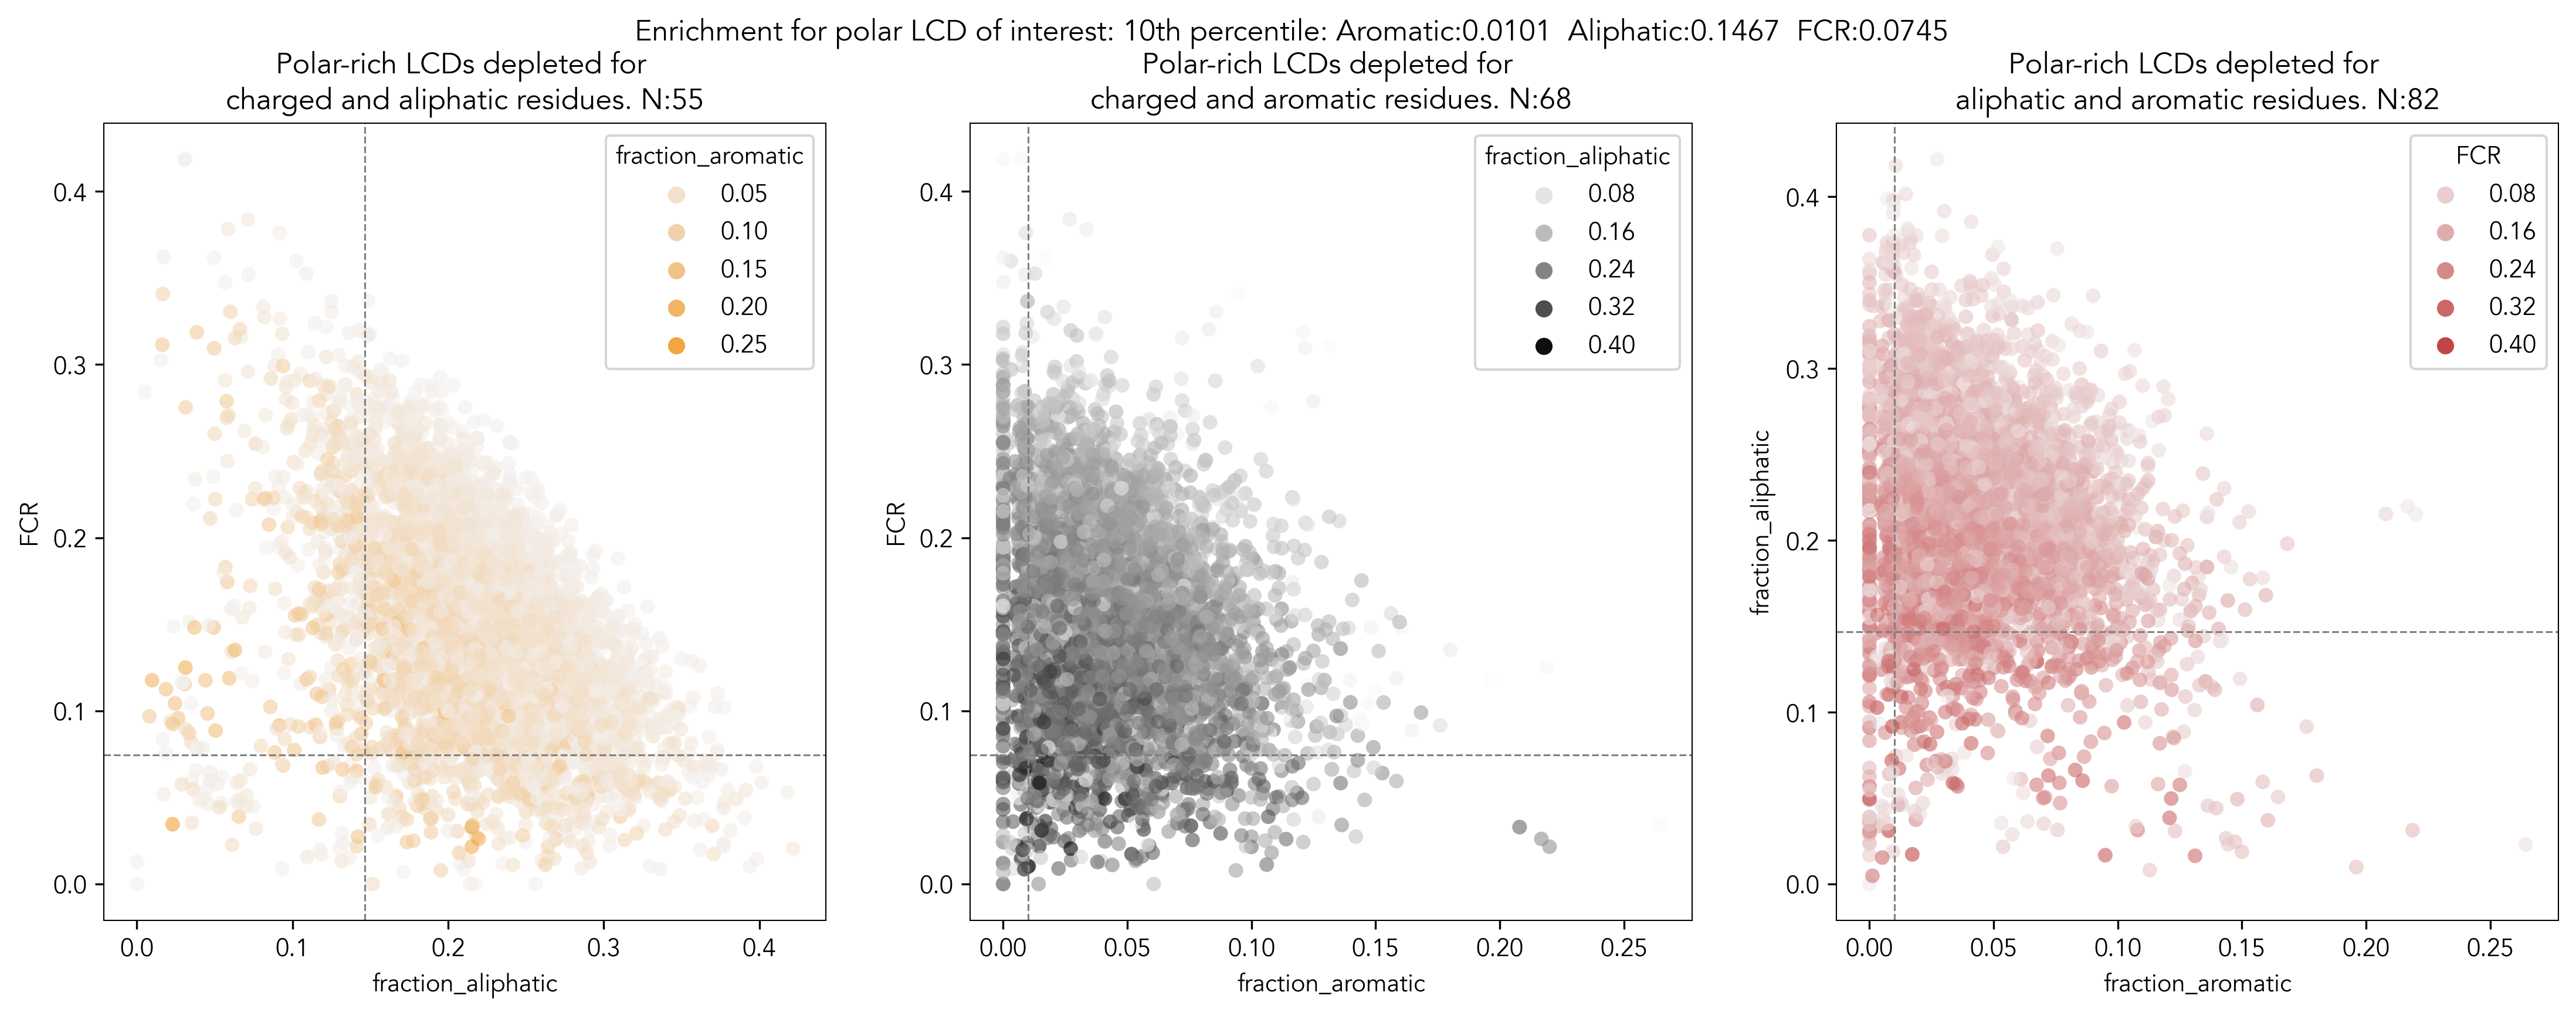

In [11]:
### Getting enrichment for spacers of interest

# setup subplot with 3 panels 
f, ax = plt.subplots(1, ncols=3, figsize=(18, 6), dpi=150, facecolor='w', edgecolor='k')

## Panel 1 ------------------------------------------------
sns.scatterplot(y='FCR', x='fraction_aliphatic', hue='fraction_aromatic', ax=ax[0], data= lcd_idr_overlap_data,
                edgecolor='None', marker='o', palette=aro_palette ,color='lightblue' ,legend=True, alpha=0.6)
n_idrs0 = len(aromatic_polar_lcds)

ax[0].set_title(f"Polar-rich LCDs depleted for \ncharged and aliphatic residues. N:{n_idrs0}")
ax[0].axhline(FCR_cutoff, ls='--', c='grey',lw=.75, label=f'{percentile}ith percentile')
ax[0].axvline(aliphatic_cutoff, ls='--', c='grey',lw=.75, label=f'{percentile}ith percentile')


## Panel 2 ------------------------------------------------
sns.scatterplot(y='FCR', x='fraction_aromatic', hue='fraction_aliphatic', ax=ax[1], data= lcd_idr_overlap_data, 
                edgecolor='None', marker='o', palette=ali_palette ,color='lightblue' ,legend=True, alpha=0.6)
n_idrs1 = len(aliphatic_polar_lcds)

ax[1].set_title(f"Polar-rich LCDs depleted for \ncharged and aromatic residues. N:{n_idrs1}")
ax[1].axhline(FCR_cutoff, ls='--', c='grey',lw=.75, label=f'{percentile}ith percentile')
ax[1].axvline(aromatic_cutoff, ls='--', c='grey',lw=.75, label=f'{percentile}ith percentile')

## Panel 3 ------------------------------------------------
sns.scatterplot(y='fraction_aliphatic', x='fraction_aromatic',hue='FCR' , ax=ax[2], data= lcd_idr_overlap_data, 
                edgecolor='None', marker='o', palette=charge_palette, legend=True, alpha=0.6)
n_idrs2 = len(FCR_polar_lcds)

ax[2].set_title(f"Polar-rich LCDs depleted for \naliphatic and aromatic residues. N:{n_idrs2}")
ax[2].axhline(aliphatic_cutoff, ls='--', c='grey',lw=.75, label=f'{percentile}ith percentile')
ax[2].axvline(aromatic_cutoff, ls='--', c='grey',lw=.75, label=f'{percentile}ith percentile')

f.suptitle("Enrichment for polar LCD of interest: %ith percentile: Aromatic:%.4f  Aliphatic:%.4f  FCR:%.4f" % (percentile ,aromatic_cutoff, aliphatic_cutoff, FCR_cutoff))




meta NOT subset; don't know how to subset; dropped


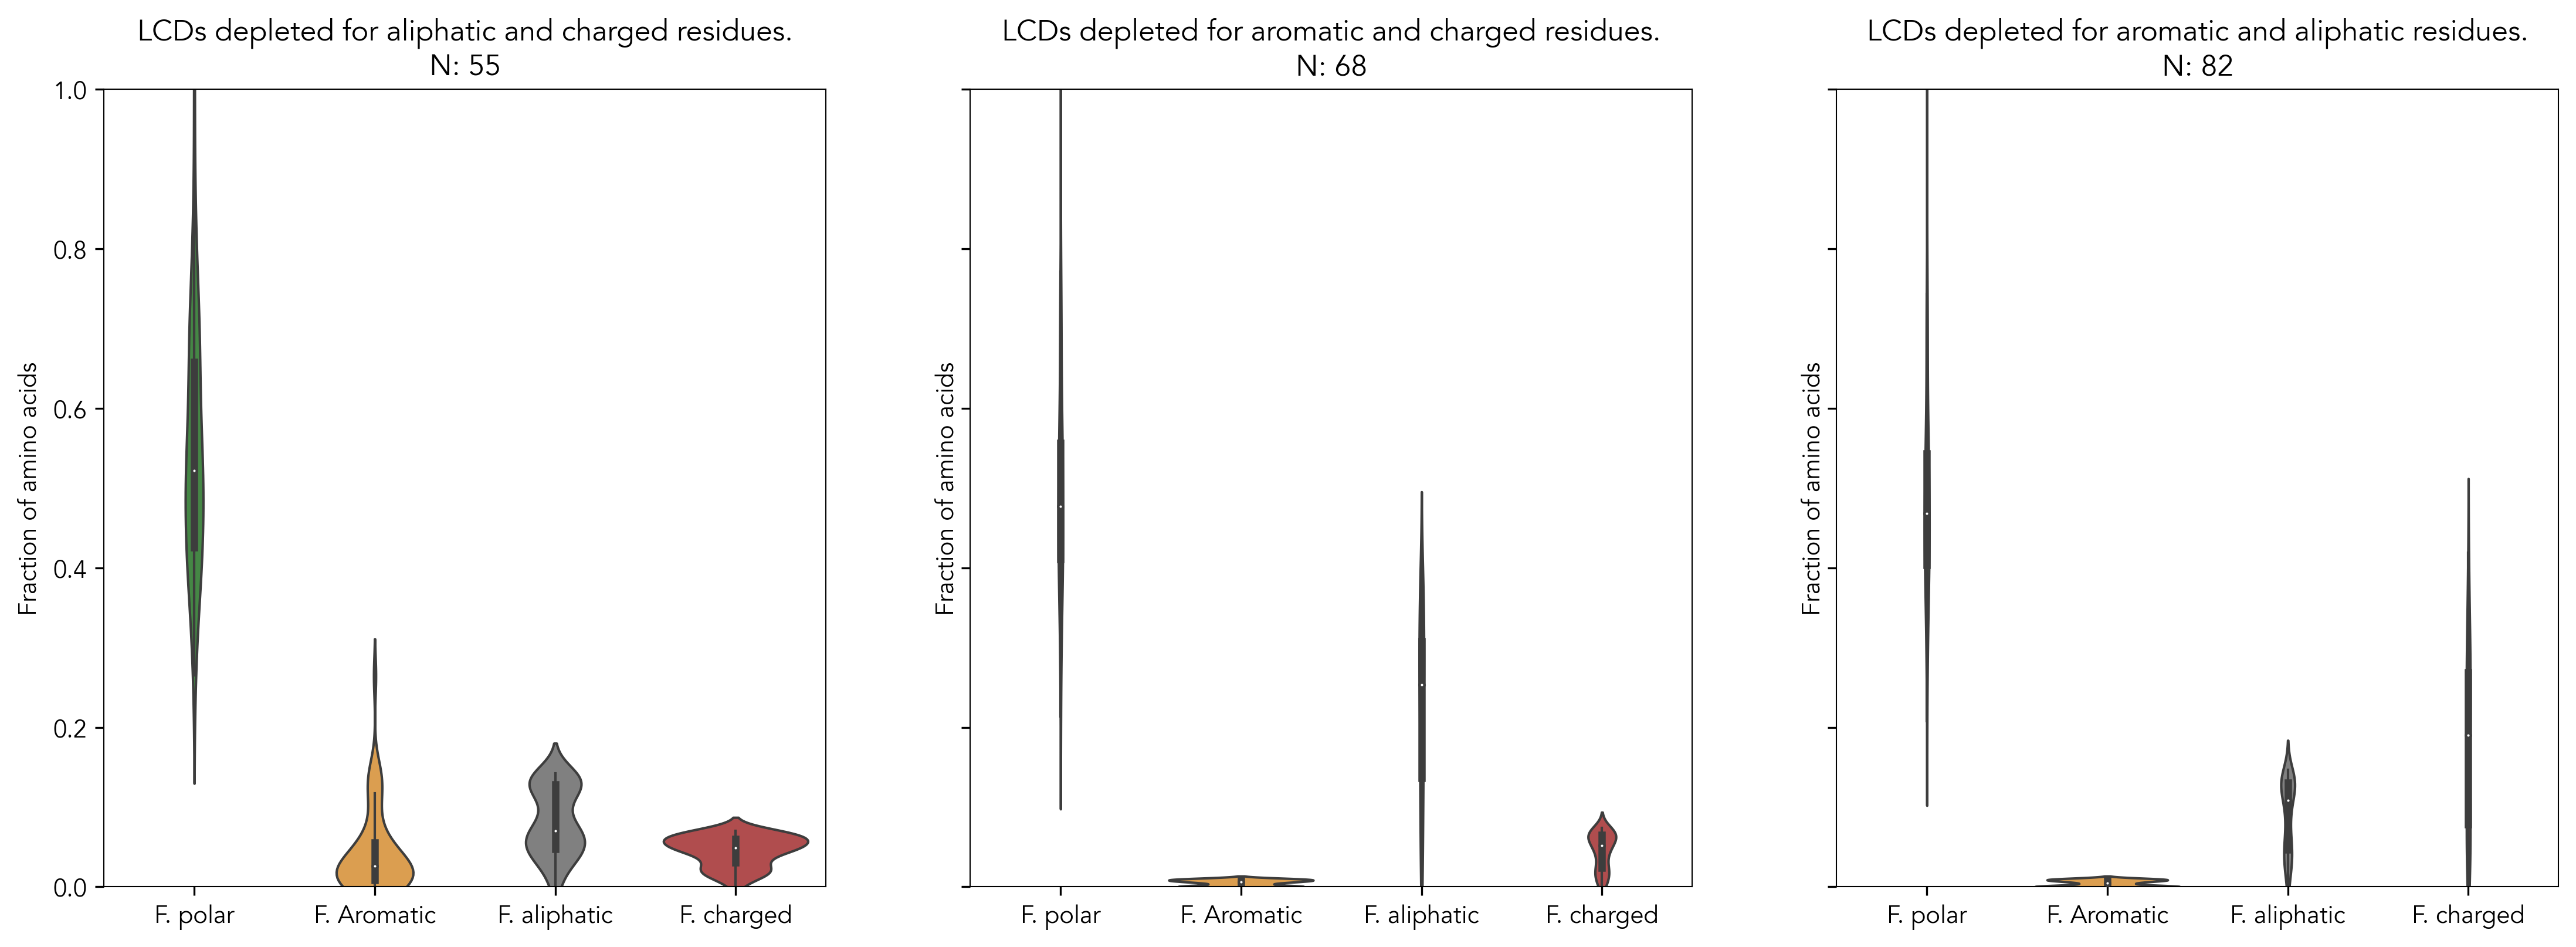

In [12]:
f, ax = plt.subplots(1,ncols=3, figsize=(18, 6), dpi=150, facecolor='w', edgecolor='k', sharey=True)

# LCDs selected because they have a low charged and low aliphatic fraction
local_data = aromatic_polar_lcds[['fraction_polar','fraction_aromatic','fraction_aliphatic','FCR']]
sns.violinplot( ax=ax[0], data= local_data, palette=chem_type_palette, linewidth=1)
n_idrs0 = len(local_data)
ax[0].set_title(f"LCDs depleted for aliphatic and charged residues.\nN: {n_idrs0}")
ax[0].set_ylabel('Fraction of amino acids')
ax[0].set_ylim([0,1])
ax[0].set_xticklabels(['F. polar','F. Aromatic','F. aliphatic','F. charged'])


# LCDs selected because they have low charged and low aromatic fractions
local_data = aliphatic_polar_lcds[['fraction_polar','fraction_aromatic','fraction_aliphatic','FCR']]
sns.violinplot( ax=ax[1], data= local_data, palette=chem_type_palette, linewidth=1)
n_idrs1 = len(local_data)
ax[1].set_ylabel('Fraction of amino acids')
ax[1].set_title(f"LCDs depleted for aromatic and charged residues.\nN: {n_idrs1}")
ax[1].set_xticklabels(['F. polar','F. Aromatic','F. aliphatic','F. charged'])

# LCDs selected because they have low aromatic and low aliphatic fraction
local_data = FCR_polar_lcds[['fraction_polar','fraction_aromatic','fraction_aliphatic','FCR']]
sns.violinplot( ax=ax[2], data= local_data, palette=chem_type_palette, linewidth=1)
n_idrs0 = len(local_data)
ax[2].set_ylabel('Fraction of amino acids')
ax[2].set_title(f"LCDs depleted for aromatic and aliphatic residues.\nN: {n_idrs2}")
ax[2].set_xticklabels(['F. polar','F. Aromatic','F. aliphatic','F. charged'])

f.savefig('../FIGURES/polar_LCDs_chemical_type.pdf')


### Get LCDs based on the co-depletion of local chemistry 

The final part of the code uses the relative_xxx fractions as calculated earlier as a way to identify LCDs that are enriched with respect to one kind of chemistry without necessarily setting a strict threshold for the others. In our cases here, as before, the chemistries of interest are aromatic, aliphatic, and charged residues, always in the backdrop of a polar-rich LCD. 


The relative_xxx thresholds define  the ratio of the chemistry of interest divided by the sum of other chemistries; i.e.

    lcd_idr_overlap_data['relative_aromatic'] 
    
Gives you the ratio of aromatic fractions divided by sum of FCR and aliphatics. At a threshold of 0.5, this means that we are really looking for LCDs where the relative_xxx chemistry is in the majority compared to other chemistries, leaving polar residues as a free contribution here. The goal is to find polar-rich LCDs that are really enriched for only one type of chemistry but allowing there to be some flexibility in terms of what the other chemistries are.

In [13]:
# depletion percentiles (all 5)
p0 = 5
p1 = 5
p2 = 5

charge_upper_percentile = 80
aro_upper_percentile = 80
ali_upper_percentile = 80


##
mode = 'enrichment'
#mode = 'all'


# define relative threshold for chemical type of interest 
r_p = 0.35

# define depletion thresholds for the combination of each chemical type 
FCR_aliphatic_cutoff = np.percentile(np.array(lcd_idr_overlap_data['FCR_aliphatic']), p0)
FCR_aromatic_cutoff = np.percentile(np.array(lcd_idr_overlap_data['FCR_aromatic']), p1) 
aliphatic_aromatic_cutoff = np.percentile(np.array(lcd_idr_overlap_data['aliphatic_aromatic']), p2)

# define upper cutoff
charge_upper_cuttoff = np.percentile(np.array(lcd_idr_overlap_data['FCR']), charge_upper_percentile)
aro_upper_cutoff = np.percentile(np.array(lcd_idr_overlap_data['fraction_aromatic']), aro_upper_percentile)
ali_upper_cutoff = np.percentile(np.array(lcd_idr_overlap_data['fraction_aliphatic']), ali_upper_percentile)



if mode == 'enrichment':
    # filter out LCDs below depletion cutoff but above chemical threshold of interest. 
    aromatic_polar_lcds_d = lcd_idr_overlap_data[(lcd_idr_overlap_data['FCR_aliphatic'] < FCR_aliphatic_cutoff) & 
                                                 (lcd_idr_overlap_data['relative_aromatic'] > r_p) &
                                                 (lcd_idr_overlap_data['fraction_aromatic'] > aro_upper_cutoff)]

    aliphatic_polar_lcds_d = lcd_idr_overlap_data[(lcd_idr_overlap_data['FCR_aromatic'] < FCR_aromatic_cutoff) & 
                                                 (lcd_idr_overlap_data['relative_aliphatic'] > r_p) &
                                                 (lcd_idr_overlap_data['fraction_aliphatic'] > ali_upper_cutoff)]


    FCR_polar_lcds_d = lcd_idr_overlap_data[(lcd_idr_overlap_data['aliphatic_aromatic'] < aliphatic_aromatic_cutoff) & 
                                            (lcd_idr_overlap_data['relative_FCR'] > r_p) &
                                            (lcd_idr_overlap_data['FCR'] > charge_upper_cuttoff)]
    
elif mode == 'all':
    # filter out LCDs below depletion cutoff but above chemical threshold of interest. 
    aromatic_polar_lcds_d = lcd_idr_overlap_data[(lcd_idr_overlap_data['FCR_aliphatic'] < FCR_aliphatic_cutoff) & 
                                                 (lcd_idr_overlap_data['relative_aromatic'] > r_p)]

    aliphatic_polar_lcds_d = lcd_idr_overlap_data[(lcd_idr_overlap_data['FCR_aromatic'] < FCR_aromatic_cutoff) & 
                                                 (lcd_idr_overlap_data['relative_aliphatic'] > r_p)]


    FCR_polar_lcds_d = lcd_idr_overlap_data[(lcd_idr_overlap_data['aliphatic_aromatic'] < aliphatic_aromatic_cutoff) & 
                                            (lcd_idr_overlap_data['relative_FCR'] > r_p)]
else: 
    raise Exception('mode should be set to one of "enrichment" or "all"')
    

print('Count in each class:')
print('-------------------------')
print(f"Aromatic-rich polar-LCDs: {len(aromatic_polar_lcds_d)}")
print(f"Aliphatic-rich polar-LCDs: {len(aliphatic_polar_lcds_d)}")
print(f"Charge-rich polar-LCDs: {len(FCR_polar_lcds_d)}")



Count in each class:
-------------------------
Aromatic-rich polar-LCDs: 92
Aliphatic-rich polar-LCDs: 133
Charge-rich polar-LCDs: 125


meta NOT subset; don't know how to subset; dropped


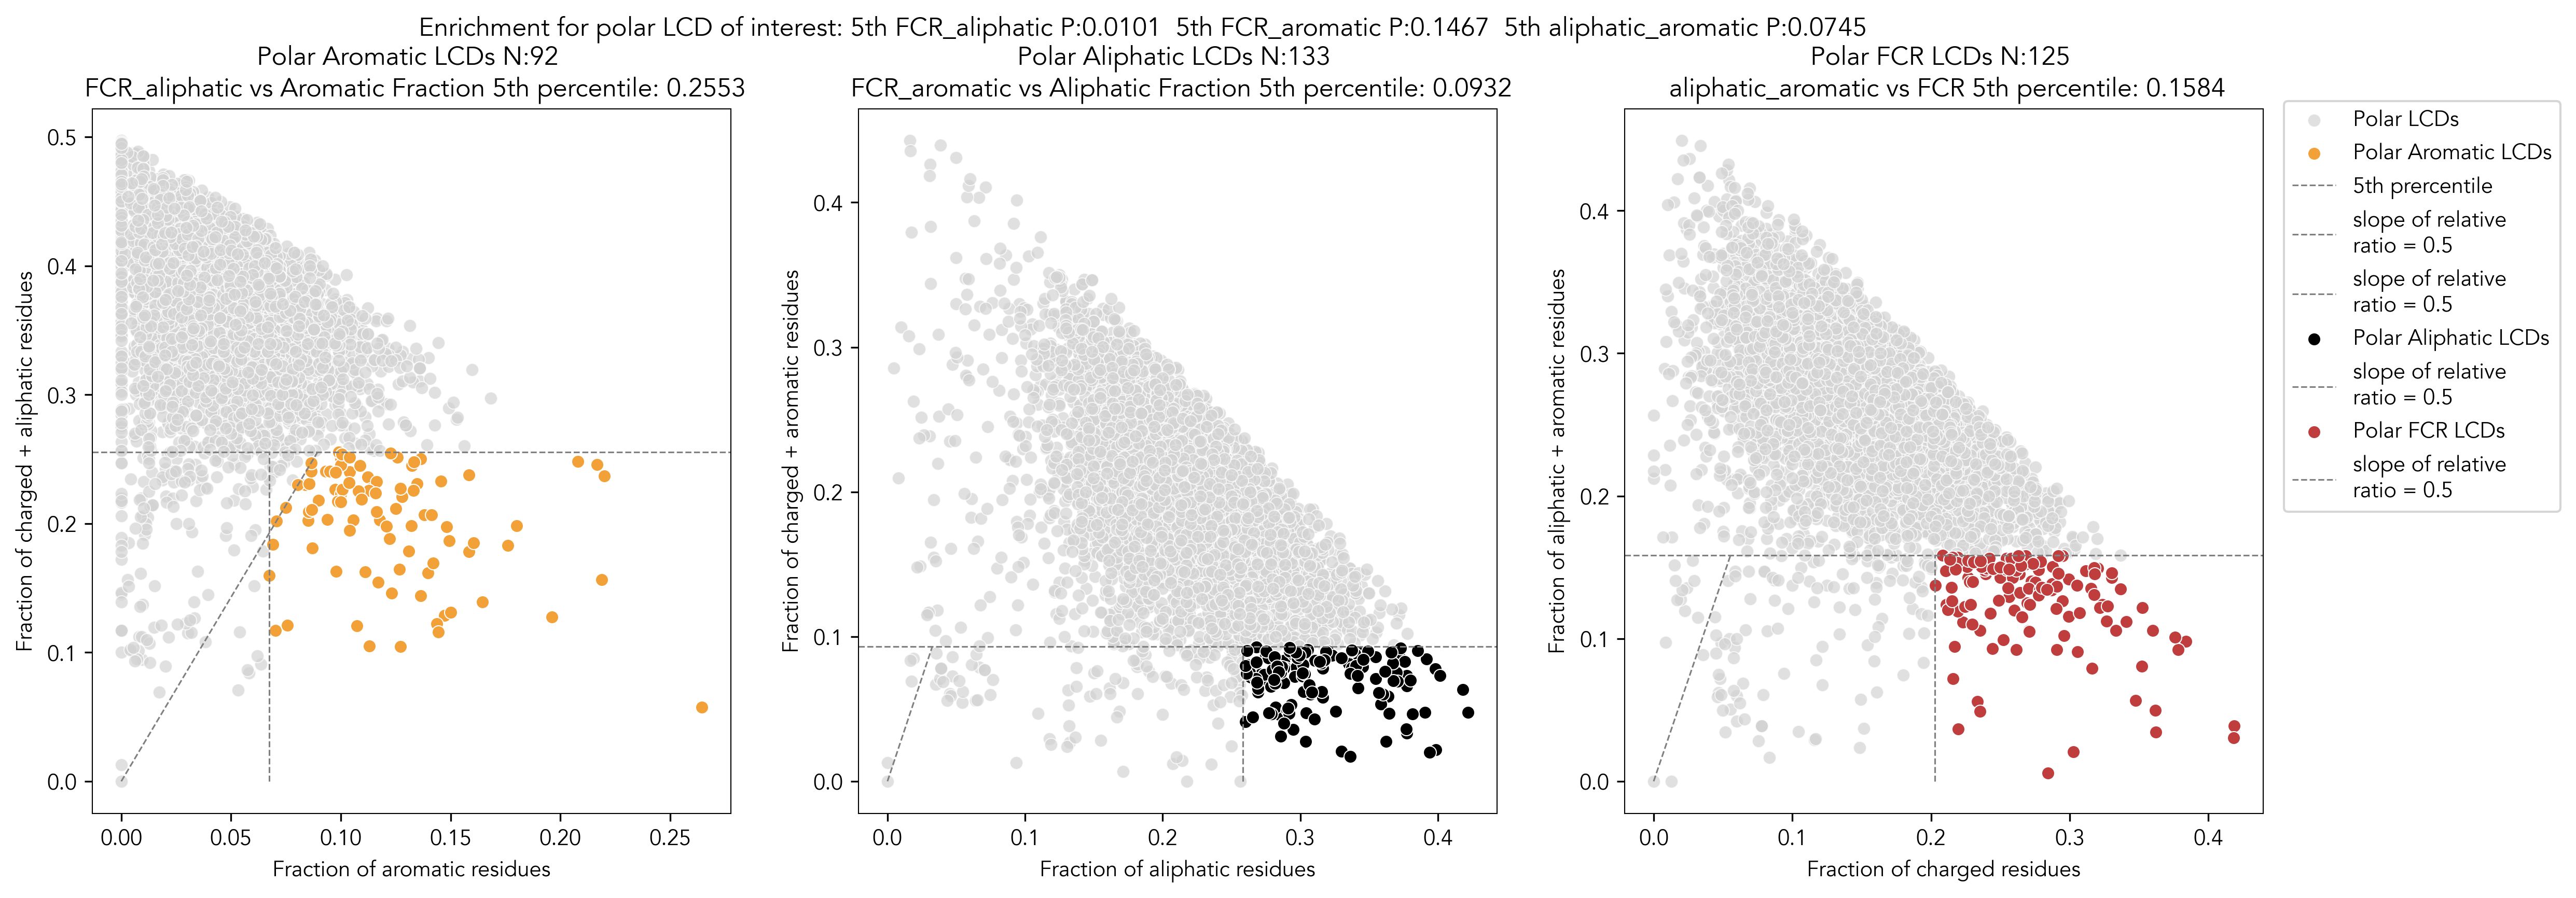

In [14]:
### Getting enrichment for spacers of interest

f, ax = plt.subplots(1,ncols=3, figsize=(18, 6), dpi=150, facecolor='w', edgecolor='k')


## Panel 1 ------------------------------------------------
n_idrs0 = len(aromatic_polar_lcds_d)
sns.scatterplot(y='FCR_aliphatic', x='fraction_aromatic', ax=ax[0], data= lcd_idr_overlap_data, marker='o',color='lightgrey', alpha=.7, label='Polar LCDs',legend=False)
sns.scatterplot(y='FCR_aliphatic', x='fraction_aromatic', ax=ax[0], data= aromatic_polar_lcds_d, marker='o',color='#f2a139', label='Polar Aromatic LCDs'   ,legend=False)
ax[0].set_title("Polar Aromatic LCDs N:%i \n FCR_aliphatic vs Aromatic Fraction %ith percentile: %.4f" % (n_idrs0,p0, FCR_aliphatic_cutoff))
ax[0].axhline(FCR_aliphatic_cutoff, ls='--', c='grey',lw=.75, label='%ith prercentile' % p0)
ax[0].plot([0,FCR_aliphatic_cutoff/(1/r_p)],[0,FCR_aliphatic_cutoff], ls='--', c='grey',lw=.75,label='slope of relative\nratio = 0.5')

if mode == 'enrichment':
    ax[0].plot([aro_upper_cutoff, aro_upper_cutoff],[0,FCR_aliphatic_cutoff], ls='--', c='grey',lw=.75,label='slope of relative\nratio = 0.5')

ax[0].set_ylabel('Fraction of charged + aliphatic residues')
ax[0].set_xlabel('Fraction of aromatic residues')

## Panel 1 ------------------------------------------------
n_idrs1 = len(aliphatic_polar_lcds_d)
sns.scatterplot(y='FCR_aromatic', x='fraction_aliphatic', ax=ax[1], data= lcd_idr_overlap_data,  marker='o',color='lightgrey', alpha=.7,legend=False)
sns.scatterplot(y='FCR_aromatic', x='fraction_aliphatic', ax=ax[1], data= aliphatic_polar_lcds_d, marker='o',color='black', label='Polar Aliphatic LCDs'  ,legend=False)
ax[1].set_title("Polar Aliphatic LCDs N:%i \n FCR_aromatic vs Aliphatic Fraction %ith percentile: %.4f" % (n_idrs1, p1, FCR_aromatic_cutoff))
ax[1].axhline(FCR_aromatic_cutoff, ls='--', c='grey',lw=.75)
ax[1].plot([0,FCR_aromatic_cutoff/(1/r_p)],[0,FCR_aromatic_cutoff], ls='--', c='grey',lw=.75)

if mode == 'enrichment':
    ax[1].plot([ali_upper_cutoff, ali_upper_cutoff],[0,FCR_aromatic_cutoff], ls='--', c='grey',lw=.75,label='slope of relative\nratio = 0.5')


ax[1].set_ylabel('Fraction of charged + aromatic residues')
ax[1].set_xlabel('Fraction of aliphatic residues')

## Panel 1 ------------------------------------------------
n_idrs2 = len(FCR_polar_lcds_d)
sns.scatterplot(y='aliphatic_aromatic', x='FCR', ax=ax[2], data= lcd_idr_overlap_data,  marker='o',color='lightgrey', alpha=.7 ,legend=False)
sns.scatterplot(y='aliphatic_aromatic', x='FCR', ax=ax[2], data= FCR_polar_lcds_d, marker='o',color='#C03D3E', label='Polar FCR LCDs' ,legend=False)
ax[2].set_title("Polar FCR LCDs N:%i \n aliphatic_aromatic vs FCR %ith percentile: %.4f" % (n_idrs2,p2, aliphatic_aromatic_cutoff))
ax[2].axhline(aliphatic_aromatic_cutoff, ls='--', c='grey',lw=.75)
ax[2].plot([0,aliphatic_aromatic_cutoff/(1/r_p)],[0,aliphatic_aromatic_cutoff], ls='--', c='grey',lw=.75)
ax[2].set_ylabel('Fraction of aliphatic + aromatic residues')
ax[2].set_xlabel('Fraction of charged residues')

if mode == 'enrichment':
    ax[2].plot([charge_upper_cuttoff, charge_upper_cuttoff],[0,aliphatic_aromatic_cutoff], ls='--', c='grey',lw=.75,label='slope of relative\nratio = 0.5')


plotting_labels = [ax.get_legend_handles_labels() for ax in f.axes]
marks, labels = [sum(lol, []) for lol in zip(*plotting_labels)]

f.legend(marks, labels, bbox_to_anchor=(1.01, .9), loc='upper right')
f.suptitle("Enrichment for polar LCD of interest: %ith FCR_aliphatic P:%.4f  %ith FCR_aromatic P:%.4f  %ith aliphatic_aromatic P:%.4f" % (p0,aromatic_cutoff, p1,aliphatic_cutoff,p2, FCR_cutoff))

f.savefig(f'../FIGURES/polar_LCDs_chemical_type_{mode}.pdf')


meta NOT subset; don't know how to subset; dropped


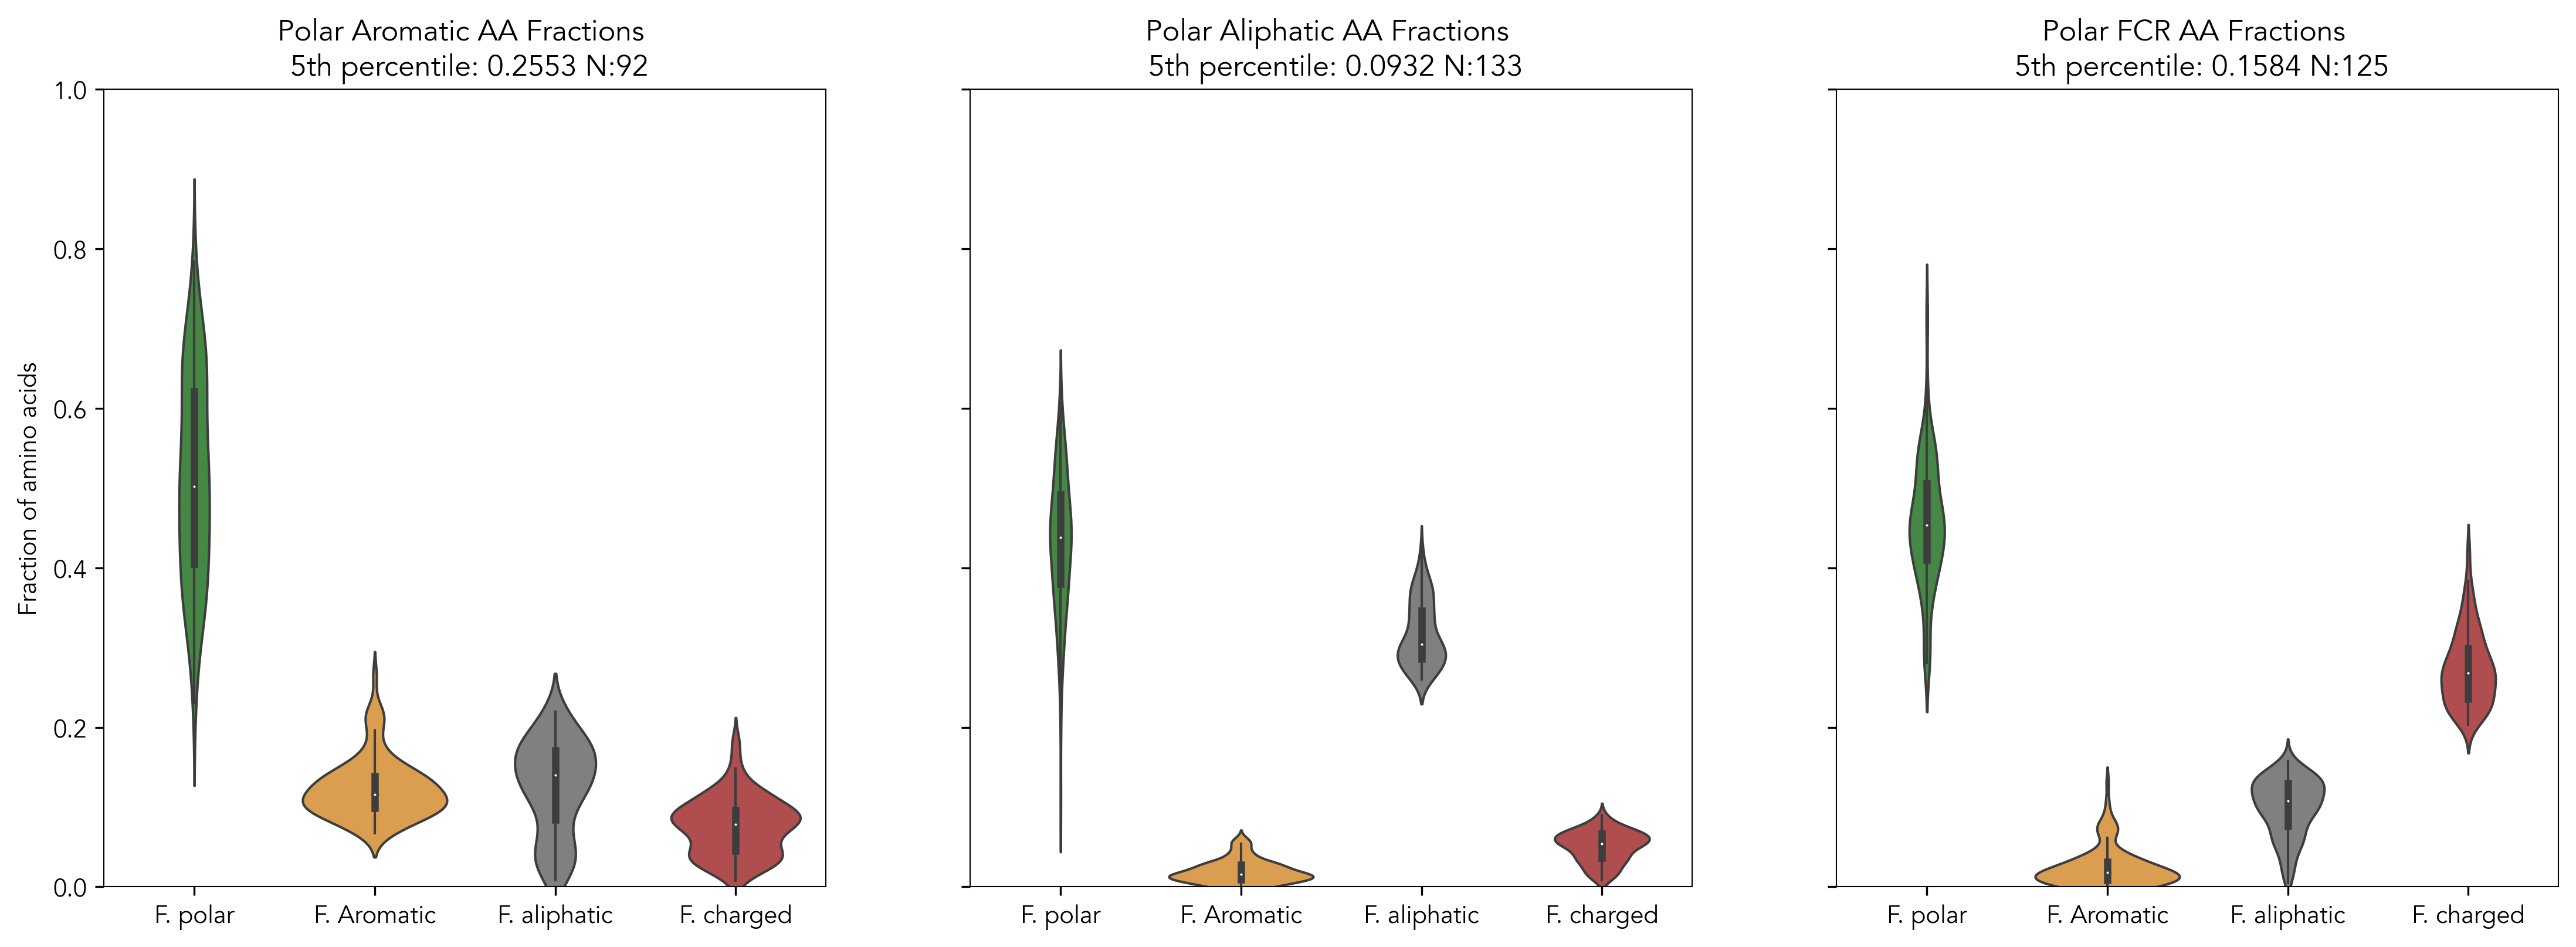

In [15]:
f, ax = plt.subplots(1,ncols=3, figsize=(18, 6), dpi=150, facecolor='w', edgecolor='k', sharey=True)

local_data = aromatic_polar_lcds_d[['fraction_polar','fraction_aromatic','fraction_aliphatic','FCR']]
sns.violinplot( ax=ax[0], data= local_data, palette=chem_type_palette,linewidth=1)
n_idrs0 = len(local_data)
ax[0].set_title("Polar Aromatic AA Fractions \n %ith percentile: %.4f N:%i" % (p0, FCR_aliphatic_cutoff,n_idrs0))
ax[0].set_ylabel('Fraction of amino acids')
ax[0].set_ylim([0,1])
ax[0].set_xticklabels(['F. polar','F. Aromatic','F. aliphatic','F. charged'])

local_data = aliphatic_polar_lcds_d[['fraction_polar','fraction_aromatic','fraction_aliphatic','FCR']]
sns.violinplot( ax=ax[1], data= local_data, palette=chem_type_palette, linewidth=1)
n_idrs1 = len(local_data)
ax[1].set_title("Polar Aliphatic AA Fractions \n %ith percentile: %.4f N:%i" % (p1, FCR_aromatic_cutoff,n_idrs1))
ax[1].set_xticklabels(['F. polar','F. Aromatic','F. aliphatic','F. charged'])

local_data =FCR_polar_lcds_d[['fraction_polar','fraction_aromatic','fraction_aliphatic','FCR']]
sns.violinplot( ax=ax[2], data= local_data, palette=chem_type_palette, linewidth=1)
n_idrs0 = len(local_data)
ax[2].set_title("Polar FCR AA Fractions \n %ith percentile: %.4f N:%i" % (p2,aliphatic_aromatic_cutoff,n_idrs2))
ax[2].set_xticklabels(['F. polar','F. Aromatic','F. aliphatic','F. charged'])

f.savefig(f'../FIGURES/polar_LCDs_chemical_distributions_{mode}.pdf')

### Evaluating for PLD overlapp 

meta NOT subset; don't know how to subset; dropped


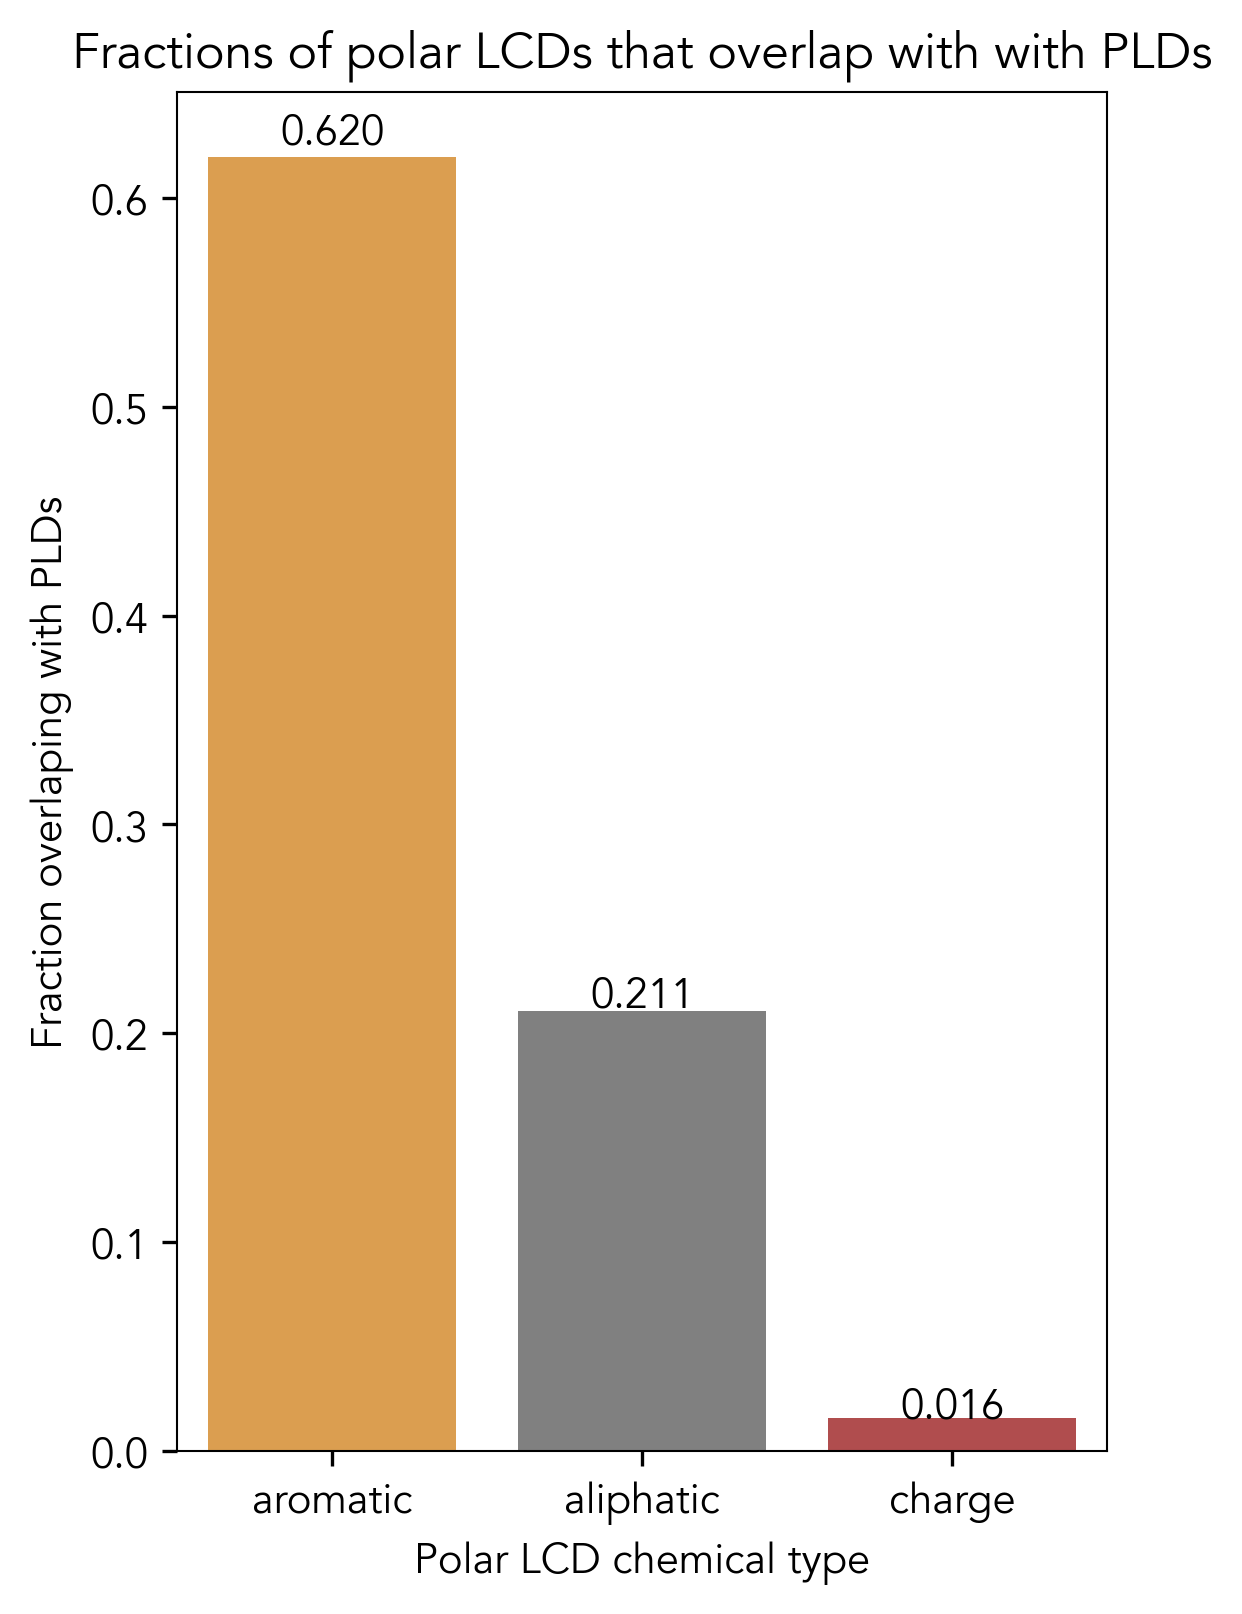

In [16]:
## Calculate and plot fraction of LCDs that overlap with PLDs 
plotting_list =[]
labels=[]
for chem,chem_lcd in [("aromatic",aromatic_polar_lcds_d), ('aliphatic',aliphatic_polar_lcds_d), ('charge',FCR_polar_lcds_d)]:
    tc =0
    pldc=0
    for d in chem_lcd['IDR']:
        if 'PLD_overlap' in d.attributes:
            pld = "plaac_pld"
            pldc+=1 
        else:
            pld = ''
        tc+=1
    plotting_list.append(pldc/tc)
    labels.append(chem)

plot = pd.DataFrame({'Polar LCD chemical type':labels, 'Fraction overlaping with PLDs':plotting_list})
f, ax = plt.subplots(1,1, figsize=(4, 6), dpi=150, facecolor='w', edgecolor='k', sharey=True)
p = sns.barplot(y='Fraction overlaping with PLDs', x='Polar LCD chemical type', palette=chem_order,data=plot, ax=ax)
ax.set_title("Fractions of polar LCDs that overlap with with PLDs")
show_values(p)

f.savefig(f'../FIGURES/polar_LCDs_PLD_overlap_{mode}.pdf')



### Distributions of number of LCDs by chemical type 
##### Based on competeing chemical type fractions  

Text(0.5, 1.0, '# of Polar Aromatic LCDs \n Aromatic Fraction vs Aliphatic Fraction')

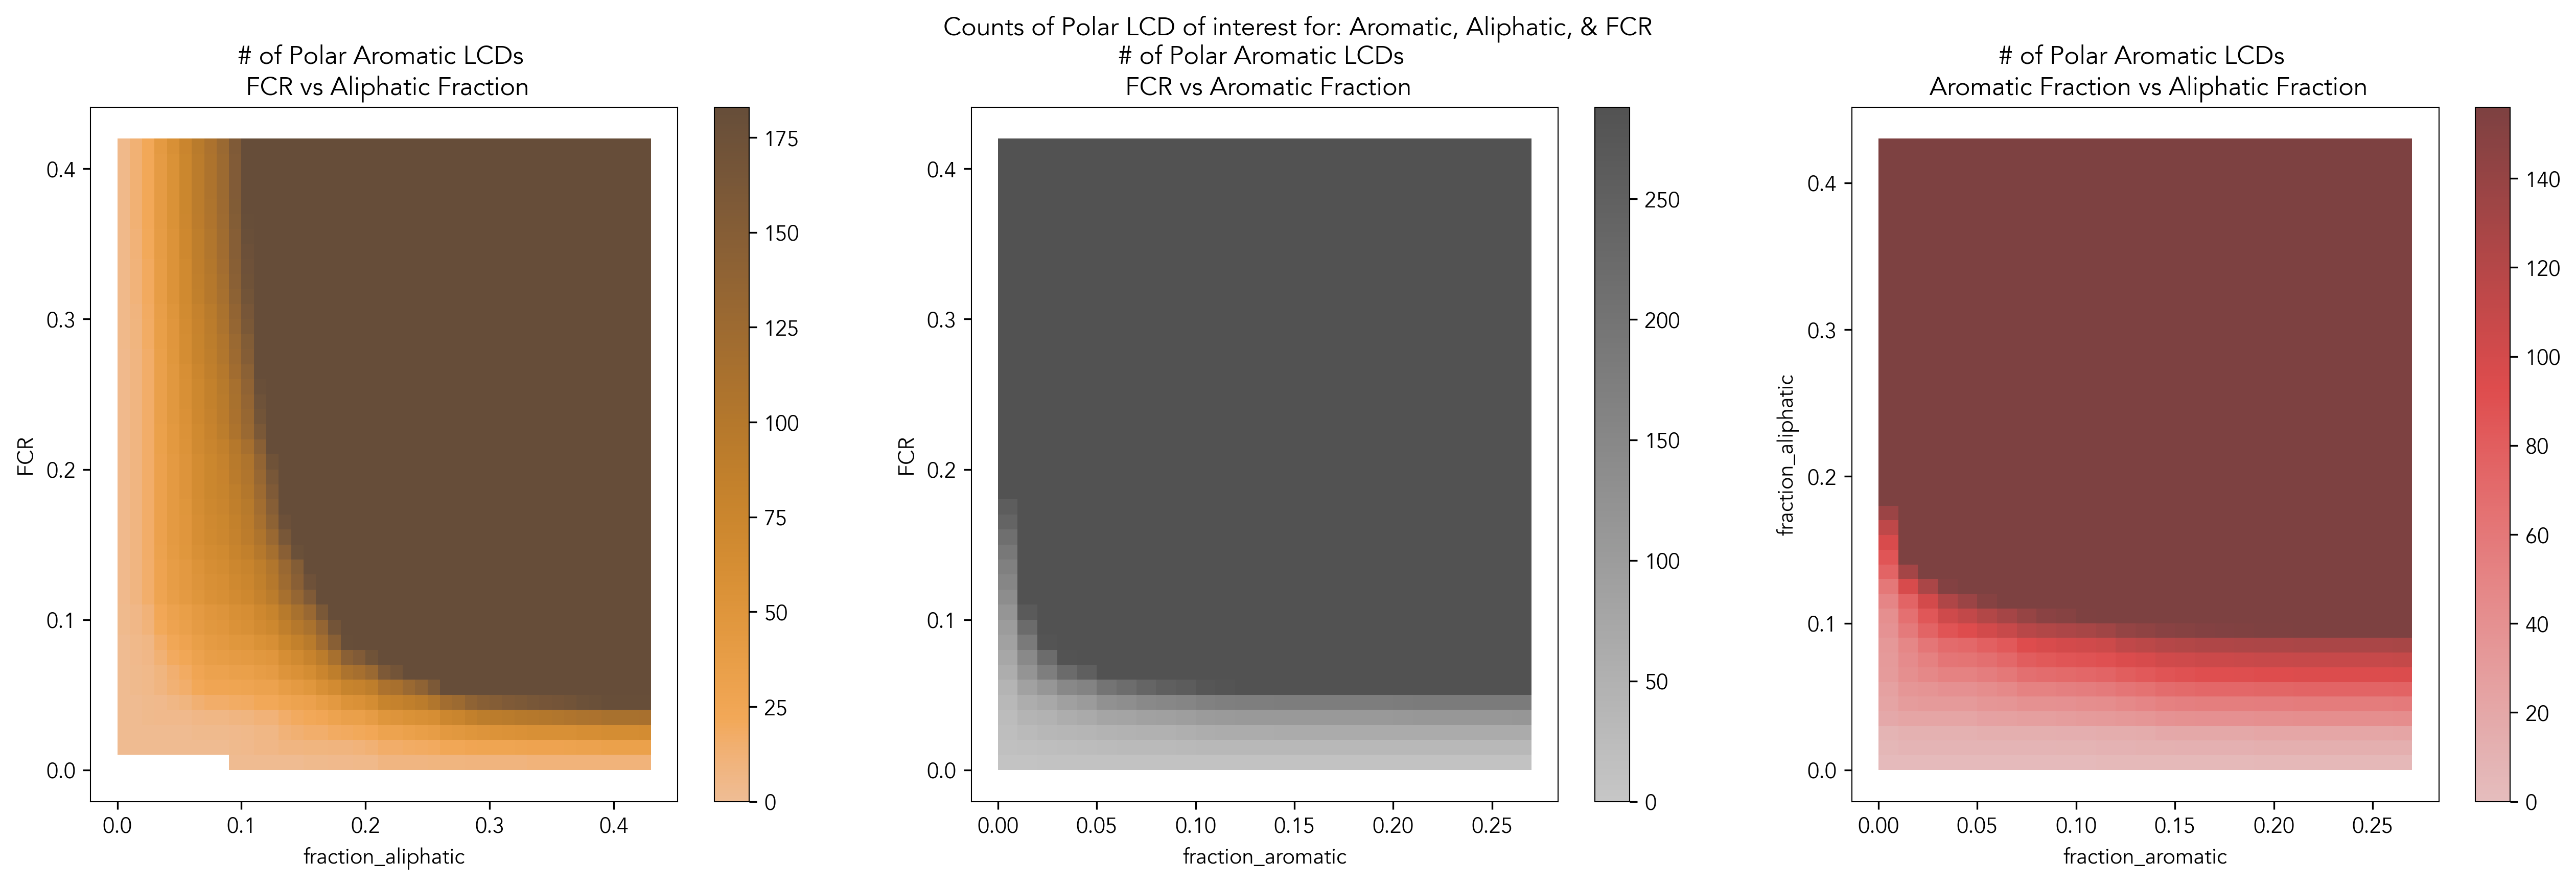

In [17]:
### Plot number of LCDs for different catagories for spacers of interest

f, ax = plt.subplots(1,ncols=3, figsize=(21, 6), dpi=150, facecolor='w', edgecolor='k')
f.suptitle("Counts of Polar LCD of interest for: Aromatic, Aliphatic, & FCR")
local_data = lcd_idr_overlap_data

aro = sns.histplot(y='FCR', x='fraction_aliphatic', ax=ax[0],data=local_data, thresh=1, binwidth=0.01, cumulative=True, pmax=.014,
             stat='count', color='#f2a139',legend=True, cbar=True)
ax[0].set_title("# of Polar Aromatic LCDs \n FCR vs Aliphatic Fraction" )


ali = sns.histplot(y='FCR', x='fraction_aromatic', ax=ax[1],data=local_data,common_bins=True,binwidth=0.01, cumulative=True,thresh=1,pmax=.005,
             stat='count', color='Grey',legend=True, cbar=True)
ax[1].set_title("# of Polar Aromatic LCDs \n FCR vs Aromatic Fraction")


chrg = sns.histplot(y='fraction_aliphatic', x='fraction_aromatic', ax=ax[2],data=local_data,common_bins=True,binwidth=0.01, cumulative=True,thresh=1,pmax=.007,
             stat='count', color='#C03D3E',legend=True, cbar=True)

ax[2].set_title("# of Polar Aromatic LCDs \n Aromatic Fraction vs Aliphatic Fraction")



##### Based on relative chemical type fractions  

Text(0.5, 1.0, '# of Polar Aromatic LCDs \n Aromatic Fraction vs Aliphatic Fraction')

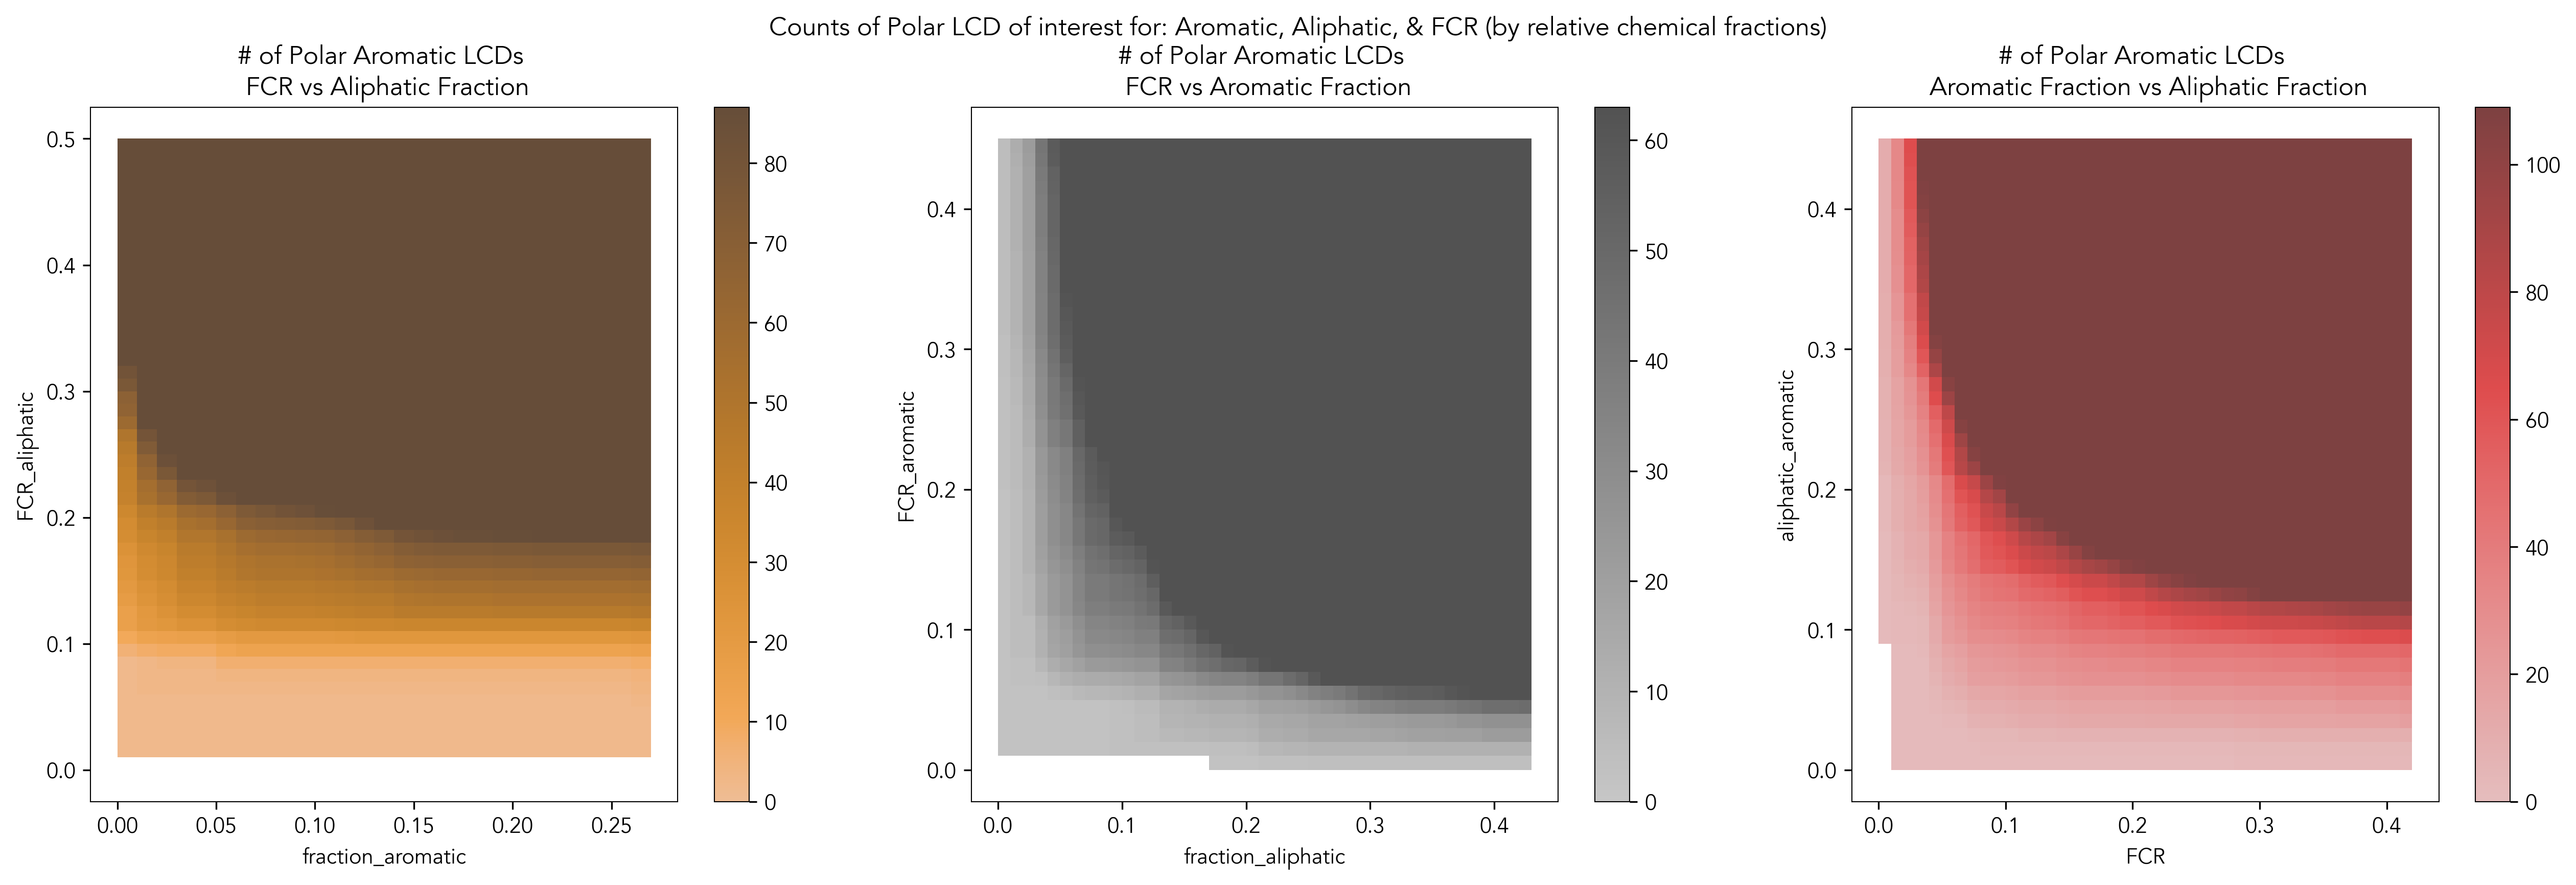

In [18]:
### Plot number of LCDs for different catagories for spacers of interest

f, ax = plt.subplots(1,ncols=3, figsize=(21, 6), dpi=150, facecolor='w', edgecolor='k')
f.suptitle("Counts of Polar LCD of interest for: Aromatic, Aliphatic, & FCR (by relative chemical fractions)")

local_data = lcd_idr_overlap_data.copy()
aro = sns.histplot(y='FCR_aliphatic', x='fraction_aromatic', ax=ax[0],data=local_data, thresh=1, binwidth=0.01, cumulative=-1, pmax=.01,
             stat='count', color='#f2a139',legend=True, cbar=True)

ax[0].set_title("# of Polar Aromatic LCDs \n FCR vs Aliphatic Fraction" )

local_data = lcd_idr_overlap_data.copy()
ali = sns.histplot(y='FCR_aromatic', x='fraction_aliphatic', ax=ax[1],data=local_data,common_bins=True,binwidth=0.01, cumulative=True,thresh=1,pmax=.005,
             stat='count', color='Grey',legend=True, cbar=True)

ax[1].set_title("# of Polar Aromatic LCDs \n FCR vs Aromatic Fraction")

local_data = lcd_idr_overlap_data.copy()
chrg = sns.histplot(y='aliphatic_aromatic', x='FCR', ax=ax[2],data=local_data,common_bins=True,binwidth=0.01, cumulative=-1,thresh=1,pmax=.01,
             stat='count', color='#C03D3E',legend=True, cbar=True)


ax[2].set_title("# of Polar Aromatic LCDs \n Aromatic Fraction vs Aliphatic Fraction")



### Save these LCDs as domains
Finally we add an attribute to these domains and then save them specifically as their own domains for future analysis and sharing.

In [19]:
aromatic_polar_lcds_d['IDR']

20      |Domain: QSGNTP_LCD (175-304, len=130) in prot...
22      |Domain: QSGNTP_LCD (2-169, len=168) in protei...
137     |Domain: QSGNTP_LCD (1156-1280, len=125) in pr...
161     |Domain: QSGNTP_LCD (3-190, len=188) in protei...
162     |Domain: QSGNTP_LCD (209-526, len=318) in prot...
                              ...                        
4603    |Domain: QSGNTP_LCD (1071-1175, len=105) in pr...
4741    |Domain: QSGNTP_LCD (770-933, len=164) in prot...
4830    |Domain: QSGNTP_LCD (1076-1469, len=394) in pr...
4876    |Domain: QSGNTP_LCD (87-167, len=81) in protei...
5031    |Domain: QSGNTP_LCD (203-375, len=173) in prot...
Name: IDR, Length: 92, dtype: object

In [20]:
# annotate each domain
for d in aromatic_polar_lcds_d['IDR'].tolist():
    d.add_attribute('aromatic_polar_lcds',True,safe=False)
    
for d in aliphatic_polar_lcds_d['IDR'].tolist():
    d.add_attribute('aliphatic_polar_lcds',True,safe=False)

for d in FCR_polar_lcds_d['IDR'].tolist():
    d.add_attribute('charged_polar_lcds',True,safe=False)
    

si_domains.write_domains_from_list(human_prot.get_domains_by_type('QSGNTP_LCD'), f'../generated_data/shprd_domains_polar_LCDs_annotated_{mode}.tsv')



